# Approximate Nearest Neighbours Search

Sometimes, when we are processing a user query, it may be **acceptable to retrieve a "good guess"** of 
nearest neighbours to the query **instead of true nearest neighbours**. In those cases, one can use an algorithm which doesn't guarantee to return the actual nearest neighbour in every case, **in return for improved speed or memory savings**. Thus, with the help of such algorithms one can do a **fast approximate search in a very large dataset**. Today we will expore one of such approaches based on graphs.

This is what we are going to do in this lab: 

1. Complete implementation of small-world graph;
2. Implement search in this graph;
3. Build a *navigable* small-world graph;
4. Compare search quality in the resulting graphs.


## 1. Dataset preparation
We will utilize the same dataset which was used in the last lab - the [dataset with curious facts](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/facts.txt). Using trained `doc2vec` [model](https://github.com/jhlau/doc2vec) (Associated Press News DBOW (0.6GB), we will infer vectors for every fact and normalize them.


### 1.1 Loading doc2vec model

In [0]:
!wget https://public.boxcloud.com/d/1/b1!pYoDizDrnvwUjLXgvZpxVm6deEuR1me7krnkfJ_LjXZkepSMHu7wmnjOl5kgLlcd9Wz_aPLYQCzqw4llU2xhndfNdMlTlvKFWPMJMsREXuqRGiAXV2eaZVaNaFvlTSkc_L4wlgAxeFxA0LK3jW61dWri7pXoMAsiknyJ75c6_LXteWIvxRStbXuFAqy_Ne-IIP79F1uI5Jv-bRYDv_Vk7dFh3vZj9dAew1oxPjWYioGuvM37K9eQJ5L5aoLh7JxgqRfbviEOScKe66rjCnQ_Mm283mOdFBzbC_Iy2l9vFa6NoGtkjt259IRcr-Fhmktbp2q-4pa7Gy0WS5Rayolu4_6gDfy_d570E68BTIBs4nkvxilMvBoK7NvbysmbxnFsISBGPjAmxOOrA_C3rxjPd-YgT9jMGgM-nV51Qr8Vqb8VlAgX4BINVCzS6Vmsm-HYiOIFBM5tfE5pY6dSc0_WZqBbPowB6mYXsh2mof4K_YUXnhGzYeJ53Em3zym49F5fY1rcLd_israuyNy9XQMWIcPlbNt_P5iiNLENQlTF0NE8iJdAkf3SNcBMXfG1td4cpkLSrM6-QsqHOt-AGph6iyIPM4qxI5EbKtYcwy7E1YA5rxQ2yehDXdqelqz9kieKoXrAYVdM-V4Rx96u-YDFcVKbry059aMIctyapXLNnYVoHmqklal54RVKAsM2HTc7hHEMQ9HWVZL2nHdxq3KOm2quHQADCdmhsehYUFEJ6LTWPcscZpL82GZIxvVLZAB4i2eNIaWh8sD7svGq1A4SQvtNleqbUlbsUlVfrsAB5Cq4iC-oo0xLSF74_scUdr6a3doByhrCx7X1Udz4i7BhmkZvqHYOUCMpviphGazZBzh8a__zkUIG9tAyFMSwznDImSFpeQVN99KxDC_scXt1wWz7nJRwaPWyBG7vbhMvQHZMusSGNaDCrXoKew-Z_YzY9_tVIgrqF6mavFsw-mH2fzCh6TqiE92Icf39ZSF2JMpd1JB1Ay5phSOu3UgqZzQOUviyOl3G_Qi1oJndAYmswvQyyP65ucOsA52NAPb3iRdKhPJ_pPtSHprxTwuVsA3OrFe4ackSRC_goMgY6JkBS06iwKbiQx975uffoFzmYPmadvD5m1Q-NLt6l6Xm0ltmaiKFEeeTzx5Nwha8Eis1OLF2NDpckNxx-ZgKKGPd5f9X3-UpmeyieCkCuQCo62GwycpZ1ESfyLOEF-RTVIIzBbaQ1I2a_LnfA9XRlcVhFN4rQxfHgYqQXJAiWFQwYy0FG48EMQZtxJx6ER6Bl18YWq4rQ2CX2JYAZ6nKgbiWMSXj/download
!tar -xvzf "./download"

--2020-02-23 04:24:01--  https://public.boxcloud.com/d/1/b1!pYoDizDrnvwUjLXgvZpxVm6deEuR1me7krnkfJ_LjXZkepSMHu7wmnjOl5kgLlcd9Wz_aPLYQCzqw4llU2xhndfNdMlTlvKFWPMJMsREXuqRGiAXV2eaZVaNaFvlTSkc_L4wlgAxeFxA0LK3jW61dWri7pXoMAsiknyJ75c6_LXteWIvxRStbXuFAqy_Ne-IIP79F1uI5Jv-bRYDv_Vk7dFh3vZj9dAew1oxPjWYioGuvM37K9eQJ5L5aoLh7JxgqRfbviEOScKe66rjCnQ_Mm283mOdFBzbC_Iy2l9vFa6NoGtkjt259IRcr-Fhmktbp2q-4pa7Gy0WS5Rayolu4_6gDfy_d570E68BTIBs4nkvxilMvBoK7NvbysmbxnFsISBGPjAmxOOrA_C3rxjPd-YgT9jMGgM-nV51Qr8Vqb8VlAgX4BINVCzS6Vmsm-HYiOIFBM5tfE5pY6dSc0_WZqBbPowB6mYXsh2mof4K_YUXnhGzYeJ53Em3zym49F5fY1rcLd_israuyNy9XQMWIcPlbNt_P5iiNLENQlTF0NE8iJdAkf3SNcBMXfG1td4cpkLSrM6-QsqHOt-AGph6iyIPM4qxI5EbKtYcwy7E1YA5rxQ2yehDXdqelqz9kieKoXrAYVdM-V4Rx96u-YDFcVKbry059aMIctyapXLNnYVoHmqklal54RVKAsM2HTc7hHEMQ9HWVZL2nHdxq3KOm2quHQADCdmhsehYUFEJ6LTWPcscZpL82GZIxvVLZAB4i2eNIaWh8sD7svGq1A4SQvtNleqbUlbsUlVfrsAB5Cq4iC-oo0xLSF74_scUdr6a3doByhrCx7X1Udz4i7BhmkZvqHYOUCMpviphGazZBzh8a__zkUIG9tAyFMSwznDImSFpeQVN99KxDC_scXt1wWz7nJRwaPWyBG7vbhMvQHZM

In [0]:
from gensim.models.doc2vec import Doc2Vec

# unpack a model into 3 files and target the main one
# doc2vec.bin  <---------- this
# doc2vec.bin.syn0.npy
# doc2vec.bin.sin1neg.npy
model = Doc2Vec.load('./apnews_dbow/doc2vec.bin', mmap=None)
print(type(model))
print(type(model.infer_vector(["to", "be", "or", "not"])))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


<class 'gensim.models.doc2vec.Doc2Vec'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


### 1.2 Reading data

In [0]:
import urllib.request
data_url = "https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/nlp/facts.txt"
file_name= "facts.txt"
urllib.request.urlretrieve(data_url, file_name)

facts = []
with open(file_name,encoding="windows-1251") as fp:
  for cnt, line in enumerate(fp):
    facts.append(line.strip('\n'))

### 1.3 Transforming sentences into vectors

In [0]:
import nltk
nltk.download('punkt')
import numpy as np

def word_tokenize(sentence):
    return nltk.word_tokenize(sentence.lower())

def get_words_from_sentence(sentences):
    for sentence in sentences: 
        yield word_tokenize(sentence.split('.', 1)[1])

sent_vecs = np.array(list(model.infer_vector(words) for words in get_words_from_sentence(facts)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 1.4 Normalizing vectors

In [0]:
def norm_vectors(A):
  An = A.copy()
  for i, row in enumerate(An):
    An[i, :] /= np.linalg.norm(row)
  return An

def find_k_closest(query, dataset, k=5):    
    index = list((i, v, np.dot(query, v)) for i, v in enumerate(dataset))    
    return sorted(index, key=lambda pair: pair[2], reverse=True)[:k]

sent_vecs_normed = norm_vectors(sent_vecs)

## 2. Small world network ##
We discussed [small world networks](https://en.wikipedia.org/wiki/Small-world_network) in lecture. This beautiful concept utilizes skip-list idea to reach query neighbourhood fastly from any random graph node. You have practically all code written, you just need to complete `rewire()` function with respect to [Watts–Strogatz process](https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model).

**Please write rewiring code.**

Function `build_graph` accepts some iterable collection of `values`. In our case this will be embeddings. 

- `K` is a parameter of Watts–Strogatz model, expressing average degree of graph nodes.
- `p` stands for probability of "rewiring".

In [0]:
import random
class Node:
    ''' Graph node class. Major properties are `value` to access embedding and `neighbourhood` for adjacent nodes '''
    def __init__(self, value, idx):
      self.value = value
      self.idx = idx
      self.neighbourhood = set()
        

def build_graph(values, K, p=0.4):
    '''Accepts container with values. Returns list with graph nodes'''
    
    N = len(values)
    nodes = [None] * N
    
    # create nodes
    for i, val in enumerate(values):
      nodes[i] = Node(val, i)
    
    # create K-regular lattice
    for i, val in enumerate(nodes):
      for j in range(i - K // 2, i + K // 2 + 1):
        if i != j:
          nodes[i].neighbourhood.add(j % N)
          nodes[j % N].neighbourhood.add(i)

    for i, node in enumerate(nodes):
      for j in range(i+1,i + K //2 + 1):
        if random.random() < p:
          k = random.randint(0,N-1)
          while(k == i) : k = random.randint(0,N-1)

          nodes[k].neighbourhood.add(i)
          nodes[i].neighbourhood.add(k)
          
          nodes[i].neighbourhood.remove(j%N)
          nodes[j%N].neighbourhood.remove(i)
        
    return nodes

The bigger `K` and `p` you choose, the longer method runs. Bigger `K` leads to bigger near-cliques in a graph and, as a consequence, bigger context to consider at each step of search. Bigger `p` is for a better "remote hops", but it should not be close to 1, as it will make graph random (not SW).

In [0]:
import time
start = time.time()
G = build_graph(sent_vecs_normed, K=10, p=0.2)
finish = time.time()
print("Graph built in {:.2f} ms".format(1000 * (finish - start)))

Graph built in 2.20 ms


### 2.1 Searching in a small-world graph

Now you need to implement an efficient search procedure which would utilize small world properties. Starting from the random node, at each step you should move towards the closest node (in terms of cosine simiarity, in our case), meanwhile keeping and refreshing top-K nearest neightbours collection. 

**Please implement basic NSW search**. 

You can refer to the `K-NNSearch` algorithm which pseudocode is given in section 4.2 of the [original paper](https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059).

`search_nsw_basic()`
- `query` - `vector` (`np.ndarray`) representing a query.
- `nsw` - SW graph.
- `top` - re-ranking set size.
- `guard_hops` - if method does not converge, we will terminate when reaching guard_hops #steps.
- `returns` - a pair of a `set` of indices and number of hops `(nearest_neighbours_set, hops)`

In [0]:
test_queries = ["good mood", "birds", "virus and bacteria"]
test_vectors = np.array([model.infer_vector(word_tokenize(q)) for q in test_queries])
test_queries_normed = norm_vectors(test_vectors)

In [0]:
import sortedcontainers
from scipy.spatial import distance

def search_nsw_basic(query, nsw, top=5, guard_hops=100):
  ''' basic search algorithm, takes vector query and returns a pair (nearest_neighbours, hops)'''
  hops = 0
  candidates = set()
  result = sortedcontainers.SortedDict({float("inf"):0})
  
  visitedSet = set()
  for i in range(guard_hops):
    entry_point = random.randint(0,len(nsw)-1)
    candidates.add(entry_point)
    tempRes = {}

    # start = time.time()
    while (len(candidates) != 0 and hops < guard_hops):
      c = candidates.pop()
      c_dist = distance.cosine(query, nsw[c].value)
      if len(result) < top :
        for e in nsw[c].neighbourhood :  
          if e not in visitedSet:
            visitedSet.add(e)
            candidates.add(e)
            e_dist = distance.cosine(query, nsw[e].value)
            tempRes.update({e_dist:e})

        hops += 1 
      else:
        cur_k_value = result.peekitem(top-1)[0]
        if c_dist > cur_k_value:
          break
        else : 
          for e in nsw[c].neighbourhood :  
            if e not in visitedSet:
              visitedSet.add(e)
              candidates.add(e)
              e_dist = distance.cosine(query, nsw[e].value)
              if e_dist < cur_k_value : 
                tempRes.update({e_dist:e})

          hops += 1
      # finish = time.time()
      # print("time : ",finish) 

      result.update(tempRes) 

  return list(dict(result).values())[:top], hops


In [0]:
search_time = 0
for i, query in enumerate(test_queries):
  start = time.time()
  ans, hops = search_nsw_basic(test_queries_normed[i], G)
  finish = time.time()
  search_time += finish - start

  print("\nResults for query:", query)
  for k in ans:
    print("\t", facts[k], "sim=", np.dot(test_queries_normed[i], sent_vecs_normed[k]))
      
print("\nBasic nsw search took {:.4f} ms on average".format(1000 * (search_time/len(test_queries))))    


Results for query: good mood
	 68. Cherophobia is the fear of fun. sim= 0.59202355
	 144. Dolphins sleep with one eye open! sim= 0.5452426
	 100. The tongue is the strongest muscle in the body. sim= 0.5288233
	 125. A ball of glass will bounce higher than a ball of rubber. sim= 0.5231798
	 110. Cats have 32 muscles in each of their ears. sim= 0.50996894

Results for query: birds
	 47. Avocados are poisonous to birds. sim= 0.7139558
	 111. Butterflies taste their food with their feet. sim= 0.6685472
	 109. Cows kill more people than sharks do. sim= 0.6383454
	 104. Sea otters hold hands when they sleep so that they do not drift apart. sim= 0.5876639
	 106. The male ostrich can roar just like a lion. sim= 0.5867424

Results for query: virus and bacteria
	 47. Avocados are poisonous to birds. sim= 0.607918
	 54. Coconut water can be used as blood plasma. sim= 0.6062611
	 39. A 2010 study found that 48% of soda fountain contained fecal bacteria, and 11% contained E. Coli. sim= 0.60551715


### 2.2 Test the search procedure

In [0]:
test_queries = ["good mood", "birds", "virus and bacteria"]
test_vectors = np.array([model.infer_vector(word_tokenize(q)) for q in test_queries])
test_queries_normed = norm_vectors(test_vectors)

First, let's display the true nearest neighbours and measure average search time. 

In [0]:
search_time = 0
for i, query in enumerate(test_queries):
    start = time.time()
    r = find_k_closest(test_queries_normed[i], sent_vecs_normed)
    finish = time.time()
    search_time += finish - start  

    print("\nResults for query:", query)
    for k, v, p in r:
        print("\t", facts[k], "sim=", p)

print("\nExact search took {:.4f} ms on average".format(1000 * (search_time/len(test_queries))))


Results for query: good mood
	 68. Cherophobia is the fear of fun. sim= 0.59344584
	 76. You breathe on average about 8,409,600 times a year sim= 0.5577691
	 144. Dolphins sleep with one eye open! sim= 0.54780835
	 97. 111,111,111 X 111,111,111 = 12,345,678,987,654,321 sim= 0.53923696
	 18. You cannot snore and dream at the same time. sim= 0.5374446

Results for query: birds
	 47. Avocados are poisonous to birds. sim= 0.7135332
	 111. Butterflies taste their food with their feet. sim= 0.66875094
	 121. Birds don’t urinate. sim= 0.64172643
	 109. Cows kill more people than sharks do. sim= 0.6407076
	 144. Dolphins sleep with one eye open! sim= 0.61201656

Results for query: virus and bacteria
	 47. Avocados are poisonous to birds. sim= 0.60784465
	 54. Coconut water can be used as blood plasma. sim= 0.60641485
	 39. A 2010 study found that 48% of soda fountain contained fecal bacteria, and 11% contained E. Coli. sim= 0.6055732
	 109. Cows kill more people than sharks do. sim= 0.5939770

Now, let's see `search_nsw_basic` in action. It should work way faster than pairwise comparisons above.

In [0]:
search_time = 0
for i, query in enumerate(test_queries):
    start = time.time()
    ans, hops = search_nsw_basic(test_queries_normed[i], G)
    finish = time.time()
    search_time += finish - start

    print("\nResults for query:", query)
    for k in ans:
        print("\t", facts[k], "sim=", np.dot(test_queries_normed[i], sent_vecs_normed[k]))
        
print("\nBasic nsw search took {:.4f} ms on average".format(1000 * (search_time/len(test_queries))))    


Results for query: good mood
	 68. Cherophobia is the fear of fun. sim= 0.6166097
	 76. You breathe on average about 8,409,600 times a year sim= 0.52935636
	 100. The tongue is the strongest muscle in the body. sim= 0.5195673
	 97. 111,111,111 X 111,111,111 = 12,345,678,987,654,321 sim= 0.51652116
	 18. You cannot snore and dream at the same time. sim= 0.51284623

Results for query: birds
	 111. Butterflies taste their food with their feet. sim= 0.6510542
	 109. Cows kill more people than sharks do. sim= 0.6387982
	 73. Scientists have tracked butterflies that travel over 3,000 miles. sim= 0.5914467
	 106. The male ostrich can roar just like a lion. sim= 0.5908794
	 68. Cherophobia is the fear of fun. sim= 0.5767305

Results for query: virus and bacteria
	 39. A 2010 study found that 48% of soda fountain contained fecal bacteria, and 11% contained E. Coli. sim= 0.62402725
	 47. Avocados are poisonous to birds. sim= 0.6083069
	 109. Cows kill more people than sharks do. sim= 0.6044575


The results you see should be worse than the exact nearest neighbours, however, not completely random. Pay attention to the similarity values.

## 3. Navigable small-world graph

When building small-world graph using Watts–Strogatz model, there was no notion of proximity between the nodes - it was completely ignored. In Navigable small-world graphs, however, the idea is to insert nodes in such a way that the cliques form real neighbourhoods, meaning points that are connected are close to each other. Please refer to section 5 of the [paper](https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059) for the details.

In [0]:
def build_navigable_graph(values, K):
  '''Accepts container with values. Returns list with graph nodes.
  K parameter stands for the size of the set of closest neighbors to connect to when adding a node'''
  #TODO implement navigable small-world graph consrtuction
  N = len(values)
  nodes = [None] * N
  
  # create nodes
  for i, val in enumerate(values):
    nodes[i] = Node(val, i)
  
  for v in nodes:
    temp = sortedcontainers.SortedDict([(distance.cosine(values[0], i),j) for j,i in enumerate(values[1:])])
    neighbors = list(temp.values())[:K]
    
    #bi-directional insert
    v.neighbourhood.update(neighbors)
    for i in neighbors:
      nodes[i].neighbourhood.add(v.idx)
              
  return nodes

### 3.1 Building and testing the graph

In [0]:
navigable_G = build_navigable_graph(sent_vecs_normed, K=10)

In [0]:
search_time = 0
for i, query in enumerate(test_queries):
    start = time.time()
    ans, hops = search_nsw_basic(test_queries_normed[i], navigable_G) 
    finish = time.time()
    search_time += finish - start
    
    print("\nResults for query:", query)
    for k in ans:
        print("\t", facts[k], "sim=", np.dot(test_queries_normed[i], sent_vecs_normed[k]))
        
print("\nSearch in navigable graph took {:.4f} ms on average".format(1000 * (search_time/len(test_queries))))  


Results for query: good mood
	 68. Cherophobia is the fear of fun. sim= 0.6166097
	 45. About half of all Americans are on a diet on any given day. sim= 0.54642195
	 76. You breathe on average about 8,409,600 times a year sim= 0.52935636
	 144. Dolphins sleep with one eye open! sim= 0.5247298
	 57. Gorillas burp when they are happy sim= 0.5226717

Results for query: birds
	 47. Avocados are poisonous to birds. sim= 0.71066236
	 121. Birds don’t urinate. sim= 0.6603135
	 111. Butterflies taste their food with their feet. sim= 0.6510542
	 109. Cows kill more people than sharks do. sim= 0.6387982
	 73. Scientists have tracked butterflies that travel over 3,000 miles. sim= 0.5914467

Results for query: virus and bacteria
	 39. A 2010 study found that 48% of soda fountain contained fecal bacteria, and 11% contained E. Coli. sim= 0.62402725
	 47. Avocados are poisonous to birds. sim= 0.6083069
	 109. Cows kill more people than sharks do. sim= 0.6044575
	 54. Coconut water can be used as blo

In [0]:
search_time = 0
for i, query in enumerate(test_queries):
    start = time.time()
    ans, hops = search_nsw_basic(test_queries_normed[i], navigable_G) 
    finish = time.time()
    search_time += finish - start
    
    print("\nResults for query:", query)
    for k in ans:
        print("\t", facts[k], "sim=", np.dot(test_queries_normed[i], sent_vecs_normed[k]))
        
print("\nSearch in navigable graph took {:.4f} ms on average".format(1000 * (search_time/len(test_queries))))  


Results for query: good mood
	 68. Cherophobia is the fear of fun. sim= 0.59210587
	 45. About half of all Americans are on a diet on any given day. sim= 0.526565
	 57. Gorillas burp when they are happy sim= 0.5145933
	 70. Pirates wore earrings because they believed it improved their eyesight. sim= 0.49504918
	 6. There are more lifeforms living on your skin than there are people on the planet. sim= 0.48445895

Results for query: birds
	 47. Avocados are poisonous to birds. sim= 0.7138059
	 111. Butterflies taste their food with their feet. sim= 0.66970384
	 12. A human will eat on average 70 assorted insects and 10 spiders while sleeping. sim= 0.593714
	 112. A tarantula can live without food for more than two years. sim= 0.5825779
	 110. Cats have 32 muscles in each of their ears. sim= 0.5541166

Results for query: virus and bacteria
	 6. There are more lifeforms living on your skin than there are people on the planet. sim= 0.5208382
	 12. A human will eat on average 70 assorted in

## 4. Comparing search quality in resulting graphs

For both graphs, for each data sample, retrieve K nearest neighbours and compare them to the true nearest neighbours of the sample. If the retrieved result is present in the true top-k list of the sample, then it is counted as a hit. For both graphs, report the total number of hits, and the average number of hits per sample.

For example: `Number of hits 394 out of 795, avg per query 2.48`

In [0]:
#TODO measure and report the described metrics
Watts_Strogatz_G_hits = 0
navigable_G_hits = 0

top = 10

N = len(sent_vecs_normed)
for i in range(N):
  Watts_Strogatz_G, _ = search_nsw_basic(sent_vecs_normed[i], G,top=top)
  navigable_ans, _ = search_nsw_basic(sent_vecs_normed[i], navigable_G,top=top)

  real_ans = [doc[0] for doc in find_k_closest(sent_vecs_normed[i], sent_vecs_normed,k=top)]

  for f in Watts_Strogatz_G :
    if f in real_ans :  Watts_Strogatz_G_hits +=1 
  
  for f in navigable_ans :
    if f in real_ans :  navigable_G_hits +=1 

tot_checks = top * N

print(f"Watts Strogatz made Graph has : {Watts_Strogatz_G_hits} hits out of {tot_checks} avg per query {Watts_Strogatz_G_hits/N}")
print(f"Navigable small-world graph has : {navigable_G_hits} hits out of {tot_checks}. avg per query {navigable_G_hits/N}")

Watts Strogatz made Graph has : 1122 hits out of 1590 avg per query 7.056603773584905
Navigable small-world graph has : 1590 hits out of 1590. avg per query 10.0


### Bonus task

Generate a small set of 2d points and build 2 types of graphs for this set: small-world graph based on Watts–Strogatz algorithm, and Navigable small-world graph. Visualize both graphs and analyze their structures - do they differ? Does Navigable small-world graph capture geometric proximity better?

In [0]:
#TODO bonus task
import plotly.graph_objects as go
from matplotlib import pyplot as plt 
%matplotlib inline

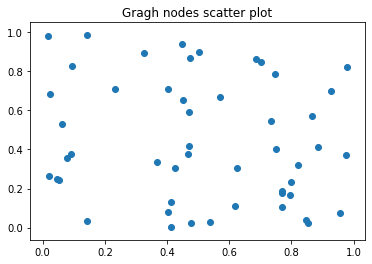

In [0]:
vertices_coordinates = np.random.random(100).reshape((-1,2))
# plt.scatter(vertices_coordinates[:,0],vertices_coordinates[:,1])
norm_vertices_coordinates = norm_vectors(vertices_coordinates)
plt.title("Gragh nodes scatter plot")
plt.scatter(vertices_coordinates[:,0],vertices_coordinates[:,1])
plt.show()

In [0]:
coordinates_navigable_G = build_navigable_graph(vertices_coordinates, K=5) # create a navigable graph with 2d points as nodes
coordinates_Watts_Strogatz_G = build_graph(vertices_coordinates, K=10, p=0.2)#create a basic graph using Watts–Strogatz model

# Create Gragh list of edges  
res_edges = set()
edge_x = []
edge_y = []

for nod in coordinates_navigable_G:
  for e in nod.neighbourhood:
    if (e, nod.idx) not in res_edges:
      res_edges.add((nod.idx, e))
      x0, y0 = nod.value
      x1, y1 = coordinates_navigable_G[e].value
      edge_x.append(x0)
      edge_x.append(x1)
      edge_x.append(None)
      edge_y.append(y0)
      edge_y.append(y1)
      edge_y.append(None)

ws_res_edges = set()
ws_edge_x = []
ws_edge_y = []

for nod in coordinates_Watts_Strogatz_G:
  for e in nod.neighbourhood:
    if (e, nod.idx) not in res_edges:
      ws_res_edges.add((nod.idx, e))
      x0, y0 = nod.value
      x1, y1 = coordinates_Watts_Strogatz_G[e].value
      ws_edge_x.append(x0)
      ws_edge_x.append(x1)
      ws_edge_x.append(None)
      ws_edge_y.append(y0)
      ws_edge_y.append(y1)
      ws_edge_y.append(None)


In [0]:
#Get the nodes positions in the 2d plane (nodes are the same for both graphs but different connections between the nodes)
node_x = []
node_y = []
for nod in coordinates_navigable_G:
    x, y = nod.value
    node_x.append(x)
    node_y.append(y)

In [0]:
# Scatter the nodes in the 2d graph 
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,name = 'navigable G Edge',
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers', name = 'Vertex',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections level',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [0]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Watts–Strogatz model & Nevigable Network Graph\n',
                titlefont_size=16,
                showlegend=True,
                hovermode='closest',
                xaxis_title = 'x-axis', yaxis_title = 'y-axis',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=True),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=True))
                )

#Show edges of Graph created using Watts–Strogatz model (Red color)
fig.add_trace(go.Scatter
              (
                x=ws_edge_x, y=ws_edge_y,name = 'Watts–Strogatz G Edge',
                line=dict(width=0.5, color='red'),
                hoverinfo='none',
                mode='lines'
              )
    
)

fig.update_traces(marker_showscale=False)
fig.show()

## **Conclusion** 
- Theoreticaly Navigable small-world graph should somehow capture geometric proximity better than a graph created using Watts–Strogatz model. Looking at the plot above it is not crystal clear. I suspect that my implementation for creating Navigable small-world has mistakes.